# Train DeepLabV3+ model with resnet-32
#### Train DeepLabv3+ with customize resnet-32 encoder

In [12]:
# Importing Important Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101
import segmentation_models_pytorch as smp
from torch.utils.data.dataloader import default_collate
from PIL import Image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
import cv2

# Data Downloading & Transformation

Below is a fuction that takes convert images to Tensor and also implemented some transformation 


In [2]:
def custom_collate(batch):
    if isinstance(batch[0], tuple):
        images, masks = zip(*batch)

        # Convert PIL images to PyTorch tensors with resize and normalization & also convert mask into RGB image
        transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((200,200)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        images = default_collate([transform(img) for img in images])
        masks = default_collate([transform(mask.convert(mode='RGB')) for mask in masks])        
    
            
        return images, masks
    # elif isinstance(batch[0], torch.Tensor):
    #     # If elements are PyTorch tensors, use the default collate function
    #     return default_collate(batch)
    # else:
    #     # For other types, use the default collate function
    #     return default_collate(batch)

DATA SET
download the data set of PASCAL VOC for segmenation and split it for training and validation and load data as Pytorch Dataloader format

In [3]:
# Download the Pascal VOC dataset
dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=False)
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=custom_collate,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False,collate_fn=custom_collate,drop_last=True)

# Modeling Section
In this section we first create RESNET-32 Architecture and then we replace an existant backbone model of deeplabV3_resnet50. After that we set loss funtion and optimizer for training. 
#### We Replace DCNN TO RESNET-32


<img src="DEEPLAB.png" alt="Alt text" title="Model" />

In [4]:
# Define a custom ResNet with 32 layers
class CustomResNet32(nn.Module):
    def __init__(self):
        super(CustomResNet32, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn =    nn.BatchNorm2d(64)
        self.relu =  nn.ReLU(inplace=True)

        # Residual blocks
        self.layer1 = self.make_layer(64, 64, 3*2)
        self.layer2 = self.make_layer(64, 128, 4*2, stride=2)
        self.layer3 = self.make_layer(128, 256, 6*2, stride=2)
        self.layer4 = self.make_layer(256, 512, 3*2, stride=2)
        
        # Global average pooling
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        #self.fc = nn.Conv2d(512, 2048, kernel_size=1)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            if (out_channels==512 and _==num_blocks-1):
                layers.append(nn.Conv2d(512, 2048, kernel_size=1, stride=1, padding=1, bias=False))
                layers.append(nn.BatchNorm2d(2048))    
                layers.append(nn.ReLU(inplace=True))
            else:
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=False))
                layers.append(nn.BatchNorm2d(out_channels))
            if _%2==0:
                layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.avgpool(x)
       # x = x.view(x.size(0), -1)  # Flatten the tensor
        # x = self.fc(x)
        
        return {"out": x}
    

#### Casecade New RESNET-32 As Backbone of DeepLABV3+

In [5]:
# The number of classes in your dataset is 21
num_classes = 21

model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes)
# Replace the backbone with CustomResNet32
model.backbone = CustomResNet32()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Before Training We first need to check if Nvidia Cuda is available or not then we Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

c:\ProgramData\Anaconda3\envs\yolo_object_detection\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\ProgramData\Anaconda3\envs\yolo_object_detection\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): CustomResNet32(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    total_batches = len(train_loader)
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        images, labels = images.to(device,dtype=torch.float32), labels.to(device,dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)['out']
        labels = labels.squeeze()
        labels = torch.argmax(labels, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_pixels += (predicted == labels).sum().item()
        total_pixels += labels.numel()


        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            # Print progress every 10 batches or at the end of an epoch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {100 * correct_pixels / total_pixels:.2f}%')

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)
            outputs = model(images)['out']
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}')

# Save the trained model
torch.save(model.state_dict(), 'deeplabv3_resnet23_pascal_voc.pth')



Epoch 1/25, Batch 0/195, Loss: 2.9576799869537354
Epoch [1/25], Batch [10/195], Loss: 1.7479, Accuracy: 49.29%
Epoch [1/25], Batch [20/195], Loss: 1.1090, Accuracy: 55.68%
Epoch [1/25], Batch [30/195], Loss: 1.1542, Accuracy: 60.98%
Epoch [1/25], Batch [40/195], Loss: 0.8721, Accuracy: 63.47%
Epoch [1/25], Batch [50/195], Loss: 0.9170, Accuracy: 64.70%
Epoch [1/25], Batch [60/195], Loss: 0.9367, Accuracy: 65.62%
Epoch [1/25], Batch [70/195], Loss: 0.7052, Accuracy: 66.48%
Epoch [1/25], Batch [80/195], Loss: 0.7778, Accuracy: 67.10%
Epoch [1/25], Batch [90/195], Loss: 0.6525, Accuracy: 67.45%
Epoch [1/25], Batch [100/195], Loss: 0.4761, Accuracy: 68.02%
Epoch 1/25, Batch 100/195, Loss: 0.8072418570518494
Epoch [1/25], Batch [110/195], Loss: 0.6478, Accuracy: 68.63%
Epoch [1/25], Batch [120/195], Loss: 0.8399, Accuracy: 68.96%
Epoch [1/25], Batch [130/195], Loss: 0.8626, Accuracy: 69.33%
Epoch [1/25], Batch [140/195], Loss: 0.7539, Accuracy: 69.38%
Epoch [1/25], Batch [150/195], Loss: 0.

# Inference


In [27]:
#Label Coloar Map Of Images
label_map = np.array([
    (0, 128, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 0, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

In [28]:
# Function That Process The Pixels According to segmentation
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()
      
    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)
  
    for label_num in range(0, len(label_map)):
        index = labels == label_num
         
        R, G, B = label_map[label_num]
  
        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B
  
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map
#Function To draw Overlay Segmented Overlay Image
def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum
  
    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  
    return image



tensor([0, 2], device='cuda:0')


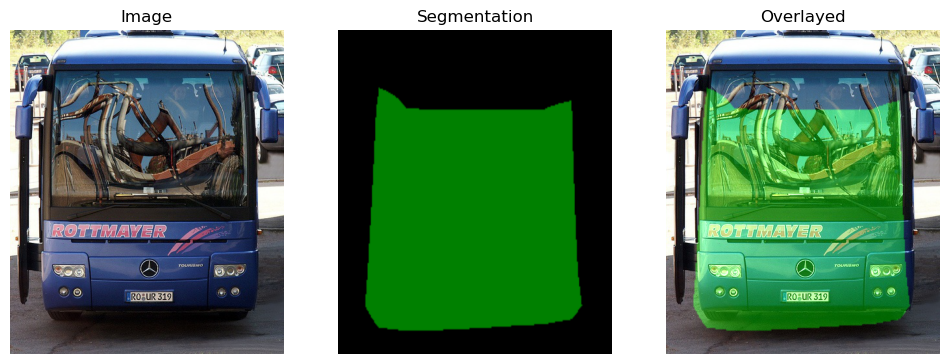

In [35]:

# Define the number of classes (adjust based on your task)
num_classes = 21

# Preprocess the image for inference
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Add other transformations as needed, such as normalization
    ])
    
    
    image = transform(image_path)
    image = image.unsqueeze(dim=0)  # Add batch dimension
    return image

# Inference on a single image
def inference(model, image_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = Image.open(image_path).convert("RGB")
    raw_image = image.copy()
    W,H= raw_image.size[:2]
    image = preprocess_image(image).to(device)
    with torch.no_grad():
        output = model(image)['out'][0]

    output_predictions =output.argmax(0)
    print(output_predictions.unique())
    
    segmented_image = draw_segmentation_map(output.cpu())
    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, (W,H), cv2.INTER_LINEAR)
    overlayed_image = image_overlay(raw_image, segmented_image)
    # Plot
    plt.figure(figsize=(12, 10), dpi=100)
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Image")
    plt.imshow(np.asarray(raw_image))

    plt.subplot(1, 3, 2)
    plt.title("Segmentation")
    plt.axis("off")
    plt.imshow(segmented_image)

    plt.subplot(1, 3, 3)
    plt.title("Overlayed")
    plt.axis("off")
    plt.imshow(overlayed_image[:, :, ::-1])
        
    plt.show()
    plt.close()

# Path to the image you want to test
image_path = "C:/Users/MSI/Desktop/Test/test 2/data/VOCdevkit/VOC2012/JPEGImages/2007_000663.jpg"

# Perform inference
data = inference(model, image_path)


